# TG43 Testing

Copyright (C) 2016-2017 Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [14]:
import numpy as np
import pandas as pd
import xarray as xr

from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [45]:
dose_rate_constant = np.squeeze(
    pd.DataFrame.from_csv('source_data/Lambda.csv', index_col=None, header=None).values)
dose_rate_constant

array(1.10942)

In [46]:
length = np.squeeze(
    pd.DataFrame.from_csv('source_data/L.csv', index_col=None, header=None).values)
length

array(0.35)

In [47]:
radial_function_table = pd.DataFrame.from_csv('source_data/g_L(r).csv')

radial_function_data = xr.DataArray(
    np.squeeze(radial_function_table.values),
    coords=[
        radial_function_table.index.values.astype(float)],
    dims=['radius_cm'])

radial_function_data

<xarray.DataArray (radius_cm: 18)>
array([ 1.276,  1.276,  1.199,  1.11 ,  1.018,  1.001,  0.995,  0.997,  0.998,
        1.   ,  1.003,  1.005,  1.008,  1.007,  1.003,  0.996,  0.972,  0.939])
Coordinates:
  * radius_cm  (radius_cm) float64 0.0 0.06 0.08 0.1 0.15 0.2 0.25 0.5 0.75 ...

In [36]:
anisotropy_function_table = pd.DataFrame.from_csv('source_data/F(r,theta).csv')

anisotropy_function_data = xr.DataArray(
    anisotropy_function_table.values,
    coords=[
        anisotropy_function_table.index.values.astype(float), 
        anisotropy_function_table.columns.values.astype(float)],
    dims=['theta_deg', 'radius_cm'])

anisotropy_function_data

<xarray.DataArray (theta_deg: 47, radius_cm: 20)>
array([[ 0.951,  0.951,  0.934, ...,  0.733,  0.768,  0.798],
       [ 0.947,  0.947,  0.93 , ...,  0.744,  0.775,  0.801],
       [ 0.944,  0.944,  0.927, ...,  0.755,  0.782,  0.804],
       ..., 
       [ 0.575,  0.575,  0.575, ...,  0.718,  0.749,  0.773],
       [ 0.536,  0.536,  0.537, ...,  0.682,  0.717,  0.746],
       [ 0.497,  0.497,  0.498, ...,  0.646,  0.685,  0.718]])
Coordinates:
  * theta_deg  (theta_deg) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 ...
  * radius_cm  (radius_cm) float64 0.0 0.06 0.08 0.1 0.15 0.2 0.25 0.3 0.35 ...

In [242]:
QA_along_away_table = pd.DataFrame.from_csv('source_data/QA_along_away.csv')

QA_along_away_data = xr.DataArray(
    QA_along_away_table.values.astype(float),
    coords=[
        QA_along_away_table.index.values.astype(float), 
        QA_along_away_table.columns.values.astype(float)],
    dims=['z_cm', 'y_cm'])

QA_along_away_data

<xarray.DataArray (z_cm: 19, y_cm: 12)>
array([[ 0.0169 ,  0.01709,  0.01724, ...,  0.01385,  0.01209,  0.01044],
       [ 0.0227 ,  0.0231 ,  0.0235 , ...,  0.01719,  0.01455,  0.01226],
       [ 0.032  ,  0.0328 ,  0.0337 , ...,  0.0213 ,  0.0175 ,  0.01432],
       ..., 
       [ 0.0279 ,  0.0304 ,  0.0324 , ...,  0.0213 ,  0.0175 ,  0.01432],
       [ 0.02   ,  0.0213 ,  0.0225 , ...,  0.01717,  0.01455,  0.01226],
       [ 0.015  ,  0.01576,  0.01647, ...,  0.01384,  0.01207,  0.01044]])
Coordinates:
  * z_cm     (z_cm) float64 7.0 6.0 5.0 4.0 3.0 2.0 1.5 1.0 0.5 0.0 -0.5 ...
  * y_cm     (y_cm) float64 0.0 0.25 0.5 0.75 1.0 1.5 2.0 3.0 4.0 5.0 6.0 7.0

## Radial function interpolation

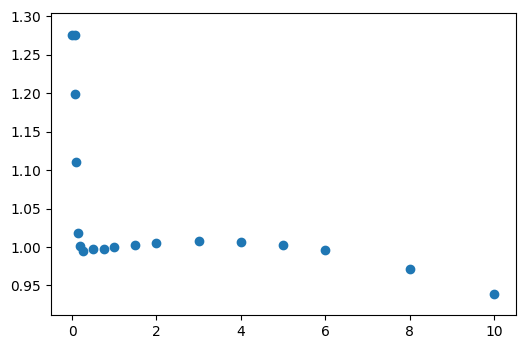

In [49]:
plt.scatter(
    radial_function_data.radius_cm,
    radial_function_data)

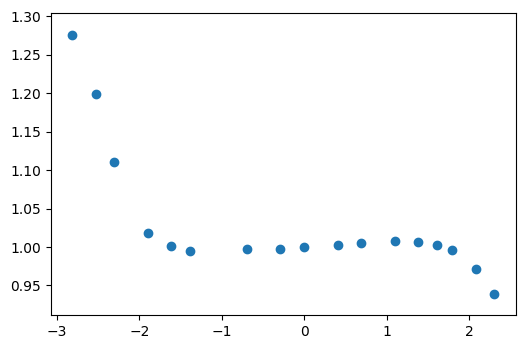

In [51]:
plt.scatter(
    np.log(radial_function_data.radius_cm[1::]),
    radial_function_data[1::])

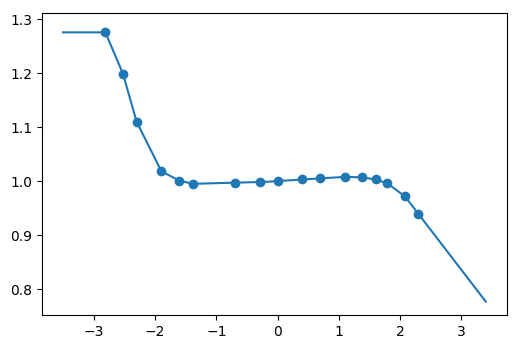

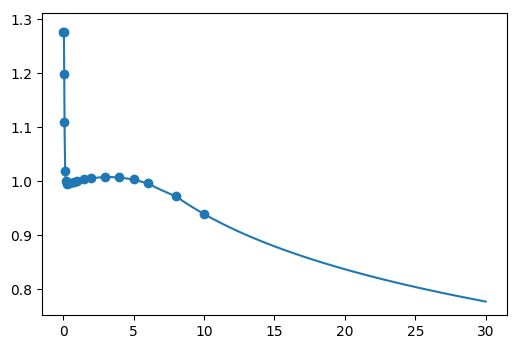

In [81]:
radial_function_interpolation = RegularGridInterpolator(
    (np.log(radial_function_data.radius_cm[1::]),),
    radial_function_data[1::],
    bounds_error=False,
    fill_value=None
)

def radial_function(radius):
    interpolation = radial_function_interpolation(np.log(radius))
    interpolation[radius < 0.06] = radial_function_data[0]
    return interpolation
    
r_test = np.linspace(0.03, 30, 10000)
y_test = radial_function(r_test)

plt.figure()
plt.scatter(
    np.log(radial_function_data.radius_cm[1::]),
    radial_function_data[1::])

plt.plot(
    np.log(r_test),
    y_test)

plt.figure()
plt.scatter(
    radial_function_data.radius_cm,
    radial_function_data)

plt.plot(
    r_test,
    y_test)

## Anisotropy function interpolation

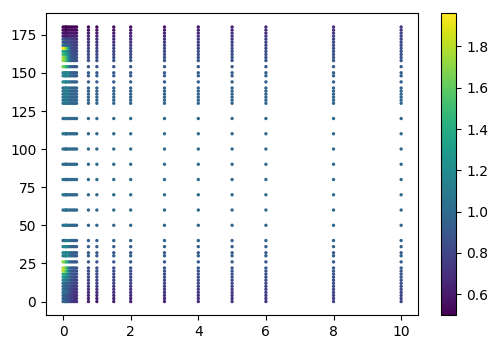

In [108]:
radius_cm_mesh, theta_deg_mesh = np.meshgrid(
    anisotropy_function_data.radius_cm,
    anisotropy_function_data.theta_deg)

plt.scatter(
    radius_cm_mesh,
    theta_deg_mesh,
    c=anisotropy_function_data,
    s=2)
plt.colorbar()

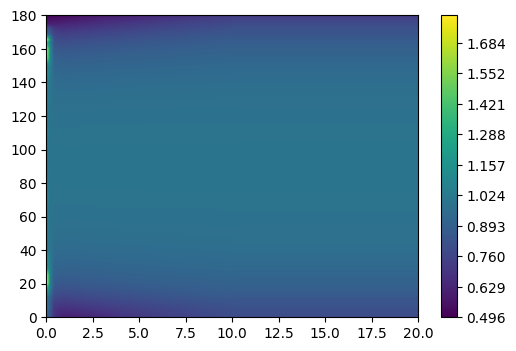

In [192]:
anisotropy_theta_deg = np.array(anisotropy_function_data.theta_deg)
anisotropy_radius_cm = np.array(anisotropy_function_data.radius_cm)

anisotropy_function_data_array = np.array(anisotropy_function_data)

anisotropy_function_linear_interpolation = RegularGridInterpolator(
    (anisotropy_theta_deg, anisotropy_radius_cm), anisotropy_function_data_array,
    bounds_error=False,
    fill_value=np.nan)

anisotropy_function_nearest_interpolation = RegularGridInterpolator(
    (anisotropy_theta_deg, anisotropy_radius_cm), anisotropy_function_data_array,
    bounds_error=False,
    fill_value=None,
    method='nearest')


def anisotropy_function(radius, theta):
    points = np.vstack([theta, radius]).T    
    linear_interpolation = anisotropy_function_linear_interpolation(points)
    
    ref = np.isnan(linear_interpolation)
    nearest_interpolation = anisotropy_function_nearest_interpolation(
        points[ref,:])
    
    linear_interpolation[ref] = nearest_interpolation
    
    return linear_interpolation


r_test = np.linspace(0, 20, 100)
theta_test = np.linspace(0, 180, 100)

r_test_mesh, theta_test_mesh = np.meshgrid(
    r_test, theta_test)

r_test_mesh_flat = r_test_mesh.ravel()
theta_test_mesh_flat = theta_test_mesh.ravel()

anisotropy_test = anisotropy_function(r_test_mesh_flat, theta_test_mesh_flat)

anisotropy_test = np.reshape(anisotropy_test, np.shape(r_test_mesh))

plt.contourf(r_test, theta_test, anisotropy_test, 1000)
plt.colorbar()

In [193]:
r_test_mesh, theta_test_mesh = np.meshgrid(
    anisotropy_radius_cm, anisotropy_theta_deg)

r_test_mesh_flat = r_test_mesh.ravel()
theta_test_mesh_flat = theta_test_mesh.ravel()

anisotropy_test = anisotropy_function(r_test_mesh_flat, theta_test_mesh_flat)
anisotropy_test = np.reshape(anisotropy_test, np.shape(r_test_mesh))

assert np.all(anisotropy_test - anisotropy_function_data_array == 0)

## Geometry Function

In [263]:
def calculate_beta(length, radius, theta):
    # http://jacmp.org/index.php/jacmp/article/viewFile/2615/1083
    theta2 = np.arctan(
        radius * np.sin(theta) / 
        (radius * np.cos(theta) - length/2))
    
    AP = radius * np.sin(theta)
    SA = radius * np.cos(theta) + length/2
    
    SP = np.sqrt(AP**2 + SA**2)
    
    beta = np.arcsin(
        length * np.sin(theta2) / 
        SP)
    
    return beta

def geometry_function(length, radius, theta):
    theta = theta / 180 * np.pi
    result = np.empty_like(radius)
    
    ref0 = (theta == 0) | (theta == np.pi)
    ref1 = (theta != 0) & (theta != np.pi)
    
    result[ref0] = (
        1 / (radius[ref0]**2 - length**2 / 4))
    
    beta = calculate_beta(
        length, radius[ref1], theta[ref1])
    result[ref1] = (
        beta / (length * radius[ref1] * np.sin(theta[ref1])))   
        
    return np.abs(result)

def normalised_geometry_function(length, radius, theta):
    geometry = geometry_function(length, radius, theta)
    ref = radius == 0
    geometry_0 = geometry_function(length, np.array([0.000001]*np.sum(ref)), theta[ref])
    
    geometry[ref] = geometry_0
    
    return (        
        geometry / 
        np.abs(calculate_beta(length, 1, np.pi/2) / length))

In [274]:
def tg43(radius, theta):
    initial_shape = np.shape(radius)
    radius_flat = np.ravel(radius)
    theta_flat = np.ravel(theta)
    
    geometry = normalised_geometry_function(length, radius_flat, theta_flat)
    radial = radial_function(radius_flat)
    anisotropy = anisotropy_function(radius_flat, theta_flat)
    
#     print(geometry)
#     print(radial)
#     print(anisotropy)
    
    result = dose_rate_constant * geometry * radial * anisotropy
    
    result = np.reshape(result, initial_shape)
    
    return result

In [268]:
def calc_on_grid(calc_grid_positions, dwell_positions, dwell_directions):
    
    calc_grid_vector = calc_grid_positions[:,None,:] - dwell_positions[None,:,:]
    
    radius = np.sqrt(
        calc_grid_vector[:,:,0]**2 + 
        calc_grid_vector[:,:,1]**2 +
        calc_grid_vector[:,:,2]**2)
    
    calc_unit_vector = calc_grid_vector / radius[:,:,None]
    dot_product = (
        dwell_directions[None,:,0] * calc_unit_vector[:,:,0] + 
        dwell_directions[None,:,1] * calc_unit_vector[:,:,1] + 
        dwell_directions[None,:,2] * calc_unit_vector[:,:,2])
    
    theta = np.arccos(dot_product) * 180 / np.pi
    nan_ref = np.isnan(theta)
    theta[nan_ref] = 90
    
    tg43_dose = tg43(radius, theta)
    
    return tg43_dose

# Testing against QA along away

In [269]:
calc_x = np.array(0)
calc_y = np.array(QA_along_away_data.y_cm)
calc_z = np.array(QA_along_away_data.z_cm)

calc_x_mesh, calc_y_mesh, calc_z_mesh = np.meshgrid(
    calc_x, calc_y, calc_z)

calc_x_mesh_flat = calc_x_mesh.ravel()
calc_y_mesh_flat = calc_y_mesh.ravel()
calc_z_mesh_flat = calc_z_mesh.ravel()

calc_grid_positions = np.array([
    [calc_x_mesh_flat[i], calc_y_mesh_flat[i], calc_z_mesh_flat[i]]
    for i in range(len(calc_x_mesh_flat))
])

dwell_positions = np.array([[0, 0, 0]])
dwell_directions = np.array([[0, 0, 1]])

tg43_dose = calc_on_grid(calc_grid_positions, dwell_positions, dwell_directions)
tg43_dose = np.reshape(tg43_dose, np.shape(calc_x_mesh))

C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log
C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:2444: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


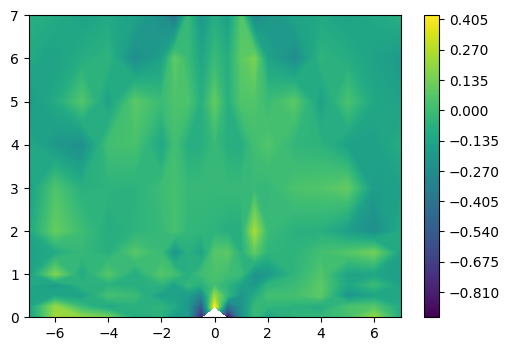

In [285]:
test_data = np.array(QA_along_away_data.T)
test_data[test_data > 1000] = np.nan

dose_difference = 100 * (tg43_dose[:,0,:] - test_data) / test_data
plt.contourf(calc_z, calc_y, dose_difference, 1000)
plt.colorbar()

## Test on a patient dicom plan